# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

This project presented some challenges, because I have very little experience with Python and that fact slowed me down a little bit.

Let's go thought the code.

At first, we have the imports.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Afterwards, we have the main function, that is called _`process_image`_ and it is responsible for putting the image through the whole process.

In [9]:
lastPoints = None

def process_image(image):
    global lastPoints
    originalImage = np.copy(image)

    # Turns image grayscale
    image = grayscale(image)
    # Applies blur
    image = gaussian_blur(image, 5)
    # Applies canny edge detection
    image = canny(image, 50, 130)
    # Defines the polygon that we are interested in and ignores the rest of the image
    image = region_of_interest(image, np.array([[(60,image.shape[0]),(430, 330), (530, 330), (image.shape[1]-60,image.shape[0])]], dtype=np.int32))
    # Uses Hough transform to detect lines in the polygon
    image = hough_lines(image, 1, np.pi / 180, 15, 30, 20)
    # Detects where each lane line starts and ends
    points = np.array(findLaneLinesPoints(image))

    # Smooths line position changes
    if (lastPoints != None):
        points = (points + 4 * lastPoints) / 5
    lastPoints = points

    # Creates new dark image
    image = image * 0
    # Draws lines over the lane lines
    draw_lines(image, points, [255, 0, 0], 6)
    # Overlays the original image with the image with the lines drawn
    image = weighted_img(image, originalImage, 1., 1., 0.)

    return image

After that, we have the _`findLaneLinesPoints`_ function, that is responsible for finding the position of the starting and ending pixels in each lane line.

In [10]:
def findLaneLinesPoints(img):
    # This function finds the starting and ending points of each of the lane lines
    # It finds the positions of these specific pixels (marked as an X):
    #        / X       X \
    #       / /         \ \
    #      / /           \ \
    #     / /             \ \
    #    / /               \ \
    #   X /                 \ X

    # Finds the first (most to left and top) red pixel on the left side of the image
    leftLine = [0, 0, 0, 0];
    for j in range(320, img.shape[0]):
        if leftLine[0] != 0:
            break
        for i in range(0, int(img.shape[1] / 2)):
            if img[j, i, 0] > 0:
                leftLine[0] = i
                leftLine[1] = j

    # Finds the last (most to right and bottom) red pixel on the left side of the image
    for j in range(img.shape[0] - 1, 320, -1):
        if leftLine[2] != 0:
            break
        for i in range(0, int(img.shape[1] / 2)):
            if img[j, i, 0] > 0:
                leftLine[2] = i
                leftLine[3] = j
                break

    # Finds the first (most to left and top) red pixel on the right side of the image
    rightLine = [0, 0, 0, 0];
    for j in range(320, img.shape[0]):
        if rightLine[0] != 0:
            break
        for i in range(int(img.shape[1] / 2), img.shape[1]):
            if img[j, i, 0] > 0:
                rightLine[0] = i
                rightLine[1] = j
                break

    # Finds the last (most to right and bottom) red pixel on the right side of the image
    for j in range(img.shape[0] - 1, 320, -1):
        if rightLine[2] != 0:
            break
        for i in range(int(img.shape[1] / 2), img.shape[1]):
            if img[j, i, 0] > 0:
                rightLine[2] = i
                rightLine[3] = j

    # Calculates the slopes of each lane line in order to extrapolate the line
    leftSlope = float(leftLine[1] - leftLine[3]) / float(leftLine[0] - leftLine[2])
    b = float(leftLine[1]) - float(leftSlope * leftLine[0])
    x = (img.shape[0] - b) / leftSlope
    leftLine[2] = int(x)
    leftLine[3] = img.shape[0]

    rightSlope = float(rightLine[1] - rightLine[3]) / float(rightLine[0] - rightLine[2])
    b = float(rightLine[1]) - float(rightSlope * rightLine[0])
    x = (img.shape[0] - b) / rightSlope
    rightLine[2] = int(x)
    rightLine[3] = img.shape[0]

    return [[leftLine, rightLine]]

After this function, all the provided helper functions are declared.

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, a=0.8, b=1., d=0.):
    return cv2.addWeighted(initial_img, a, img, b, d)

Finally, we have the part that will use the _`process_image`_ fuction to process an image or video.

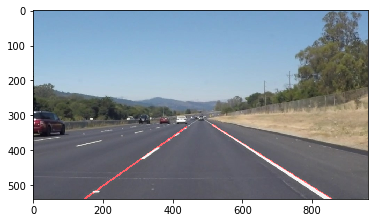

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:19<00:00, 13.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [12]:
# Opens up image and processes it
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = process_image(image)
plt.imshow(image)
plt.show()

# Opens up video and processes it
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

Next, we can see the result of putting a video through the program:

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/solidWhiteRight.mp4">
</video>
""".format(white_output))